# Computing with Sets of Probabilities (or Imprecise Probabilities) in Julia

## Getting familiar with the p-box representation in [ProbabilityBoundsAnalysis.jl](https://andergray.github.io/ProbabilityBoundsAnalysis.jl/dev/)

In [1]:
import Pkg; 
Pkg.activate("lab2")
Pkg.add(name="ProbabilityBoundsAnalysis"); 
Pkg.add(url="https://github.com/sisl/NeuralVerification.jl"); 
Pkg.add(name="LazySets"); 
Pkg.add(name="IntervalArithmetic"); 
Pkg.add(name="Distributions"); 
#Pkg.add(name="DataFrames"); 
#Pkg.add(name="SplitApplyCombine",); 
Pkg.add(name="PyPlot"); 
Pkg.add(name="Plots")
# Pkg.add(name="ProbabilityBoundsAnalysis", version="0.2.11"); 
# Pkg.add(url="https://github.com/sisl/NeuralVerification.jl"); 
# Pkg.add(name="LazySets", version="2.11.3"); 
# Pkg.add(name="IntervalArithmetic",version="0.20.9"); 
# Pkg.add(name="Distributions", version = "0.25.107"); 
# Pkg.add(name="DataFrames", version="1.6.1"); 
# Pkg.add(name="SplitApplyCombine",version="1.2.3"); 
# Pkg.add(name="PyPlot", version = "2.11.2"); 
# Pkg.add(name="Plots", version="1.39.0")

using NeuralVerification, LazySets
import NeuralVerification: Network, Layer, ReLU, Id, compute_output, ActivationFunction, get_bounds
using Plots
using LinearAlgebra

#import Pkg; Pkg.add("ProbabilityBoundsAnalysis")
#Pkg.add("PyPlot")
using ProbabilityBoundsAnalysis, PyPlot, IntervalArithmetic
#Matplotlib needs to be installed on your computer. If it is not, it can be installed by
#julia -e 'ENV["PYTHON"]=""; using Pkg; Pkg.add("Conda"); using Conda; Conda.add("matplotlib"); Pkg.add("PyCall"); Pkg.build("PyCall"); Pkg.add("PyPlot");'

  Activating project at `~/verification-neural-networks/NeuralVerification-CARS-Workshop-master/lab2`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed InverseFunctions ───── v0.1.17
   Installed GPUArraysCore ──────── v0.1.6
   Installed ChangesOfVariables ─── v0.1.9
   Installed OpenBLAS32_jll ─────── v0.3.17+0
   Installed GenericLinearAlgebra ─ v0.3.14
   Installed DensityInterface ───── v0.4.0
   Installed IterTools ──────────── v1.4.0
  No Changes to `~/verification-neural-networks/NeuralVerification-CARS-Workshop-master/lab2/Project.toml`
    Updating `~/verification-neural-networks/NeuralVerification-CARS-Workshop-master/lab2/Manifest.toml`
  [8bb1440f] + DelimitedFiles v1.9.1
  [0dad84c5] ~ ArgTools ⇒ v1.1.1
  [f43a241f] ~ Downloads ⇒ v1.6.0
  [7b1f6079] + FileWatching
  [b27032c2] ~ LibCURL ⇒ v0.6.3
  [ca575930] ~ NetworkOptions ⇒ v1.2.0
  [44cfe95a] ~ Pkg ⇒ v1.9.2
  [ea8e919c] ~ SHA ⇒ v0.7.0
  [10745b16] ~ Statistics ⇒ 

### Representation and construction of p-boxes

Let us first define the utility function split, which returns the DSI (Dempster Shafer Interval) representation of a [P-box](https://en.wikipedia.org/wiki/Probability_box), under the form of an array of focal elements and an array of weights. We will use it slightly later.

In [2]:
import ProbabilityBoundsAnalysis: split
function split(F :: pbox) 
    n = length(F.u)
    focal_el = interval.(F.u, F.d) 
    masses = ones(n) ./n
    return focal_el, masses
end

split (generic function with 9 methods)

The discretization steps pf P-boxes, which corresponds to the number of focal elements used to represent 
the sets of probabilities, can be defined using function setSteps.

In [3]:
ProbabilityBoundsAnalysis.setSteps(50)

50

Let us now [build a P-box](https://andergray.github.io/ProbabilityBoundsAnalysis.jl/dev/pboxes/) enclosing Normal distributions: a is the p-box representation of a Normal distribution of mean 0 and variance 0.1. The list of supported distributions is available in the [documentation](https://andergray.github.io/ProbabilityBoundsAnalysis.jl/dev/pboxes/).

In [4]:
a = normal(0,0.1)

Pbox: 	  ~ normal ( range=[-0.30902, 0.30902], mean=0.0, var=0.01)

Function PyPlot.plot allows us to represent graphically the pbox, by printing the lower and uper bounds on Cumulative distribution functions as plaine black/red lines. The probability distributions represented are all those lying in the grey region in-between the lower and upper CDFs.

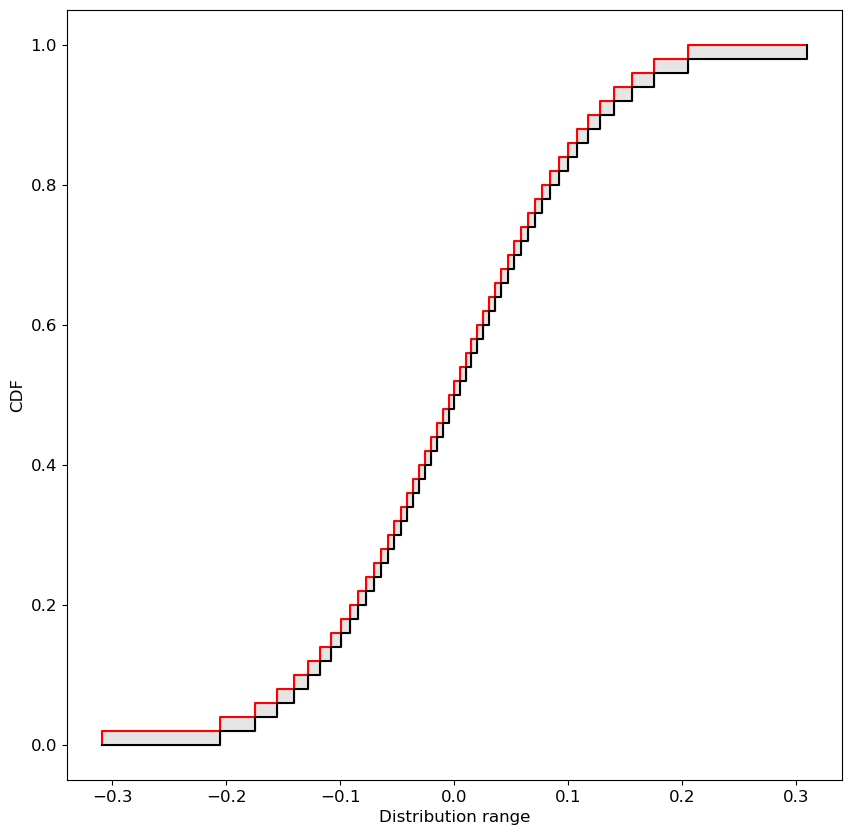

In [5]:
PyPlot.plot(a)
PyPlot.display_figs()

An interval can be converted in a P-box as follows:

Pbox: 	  ~  ( range=[0.0, 1.0], mean=[0.0, 1.0], var=[0.0, 0.25])


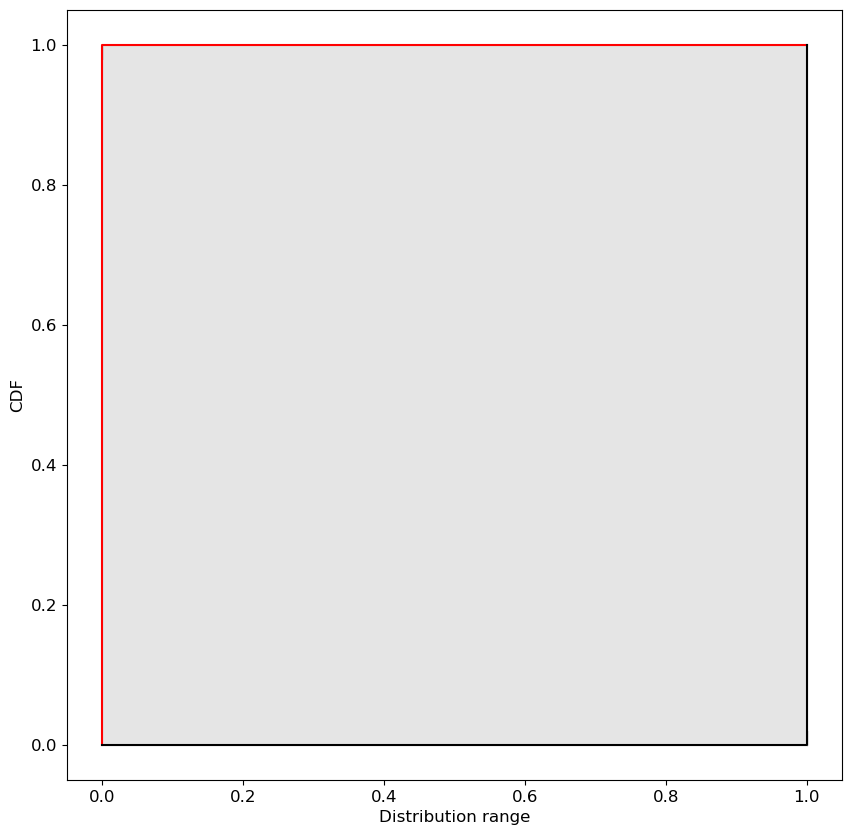

In [6]:
c = makepbox(interval(0,1))
print(c,"\n")
PyPlot.plot(c)
PyPlot.display_figs()

Can you explain the representation obtained ?

P-boxes can also be defined by using a distributions shape but with interval parameters:

Pbox: 	  ~ normal ( range=[-3.0902, 4.0902], mean=[0.0, 1.0], var=1.0)


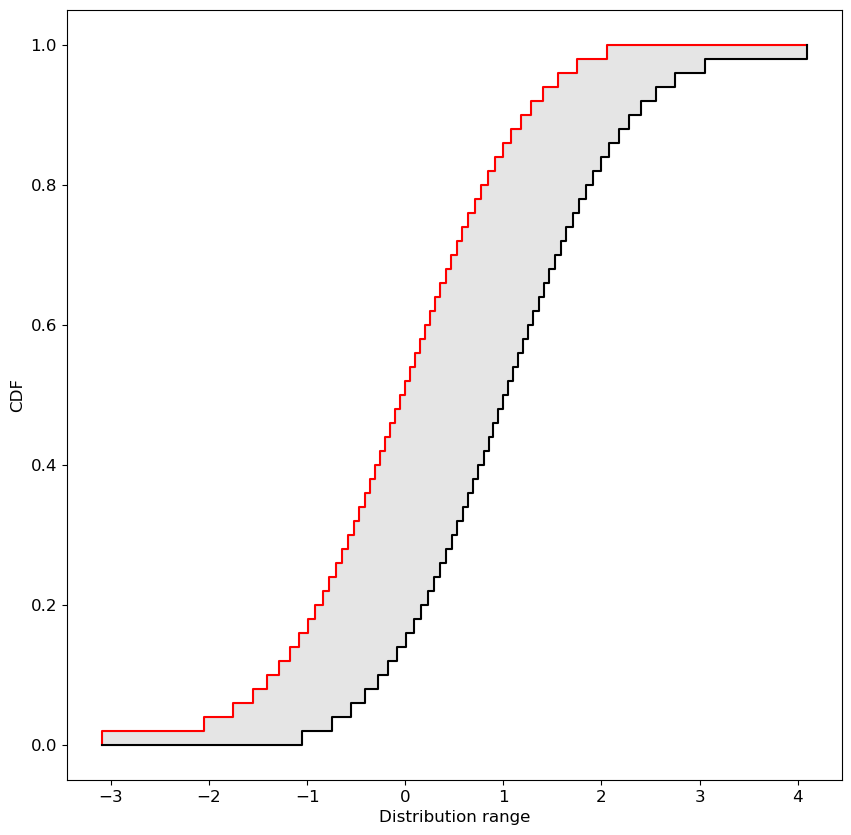

In [7]:
c = normal(interval(0,1),1)
print(c,"\n")
PyPlot.plot(c)
PyPlot.display_figs()

### [Arithmetic on P-boxes]((https://andergray.github.io/ProbabilityBoundsAnalysis.jl/dev/arithmetic/))

The classical binary arithmetic operations can be performed on P-boxes. The default operations are Frechet operations, which consider all possible dependencies between inputs. These Frechet operations produce P-boxes, even when starting from precisely known distributions:

Pbox: 	  ~  ( range=[7.9098, 15.09], mean=11.5, var=[0.31981, 2.3499])


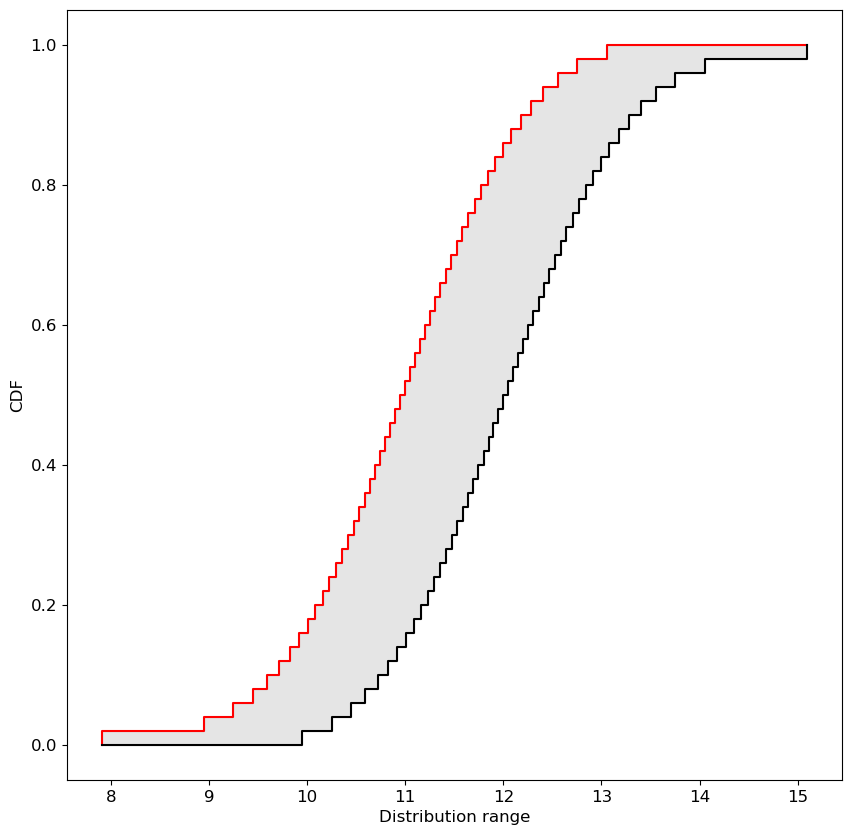

In [8]:
a1 = normal(10,1); 
a2 = uniform(1,2);
a3 = a1 + a2
print(a3,"\n")
PyPlot.plot(a3)
PyPlot.display_figs()

Writing a3 = a1 + a2 is equivalent to explicitely calling the Frechet addition as follows:

In [9]:
a3 = convFrechet(a1, a2, op = +) # inputs dependent

Pbox: 	  ~  ( range=[7.9098, 15.09], mean=11.5, var=[0.31981, 2.3499])

When the inputs are known to be independent, the following operator can be used, which results in a subset of the above set of distributions:

Pbox: 	  ~  ( range=[7.9098, 15.09], mean=11.5, var=1.0833)


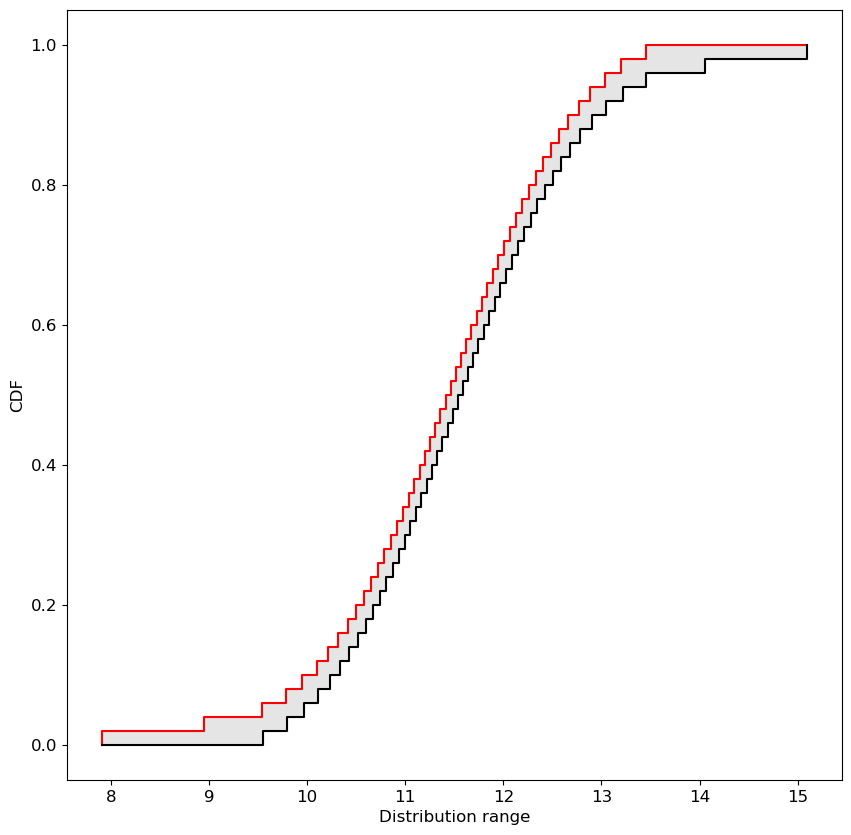

In [10]:
a4 = convIndep(a1, a2, op = +) # inputs independent
print(a4,"\n")
PyPlot.plot(a4)
PyPlot.display_figs()

### Comparisons and queries on P-Boxes

A P-box can be compared to a real number: X <= x corresponds to the evaluation of the CDF P(X <=x):

For instance below, the probability that a3 is negative is 0, so that test a3 <= 0.0 answers false:

In [11]:
a3 <= 0.0

false

The probability that a3 is lower or equal to 11.0 is bounded in an interval which corresponds to a cut of the set of distributions that can be observed on the CDF plots:

In [12]:
a3 <= 11.0

[0.14, 0.520001]

Calling test X <= x is equivalent to calling cdf(X,x), for instance here:

In [13]:
cdf(a3,11.0)

[0.14, 0.520001]

The possible values of probability P(a4 <= 11.0) are naturally included in the set of values of P(a3 <= 11.0), since a4 is a restriction of a3:

In [14]:
a4 <= 11.0

[0.3, 0.34]

Finally, p-boxes can be compared, for instance:

In [15]:
a3 <= a4

[0, 1]

How can this result be interpreted ?

### Accessing the representation of P-boxes

Let us now decrease the discretization steps in order to examine closer the pbox representation.

In [16]:
ProbabilityBoundsAnalysis.setSteps(4)

4

We now define b similarly to a, but with this larger discretization step.

Pbox: 	  ~ normal ( range=[-0.30902, 0.30902], mean=0.0, var=0.01)


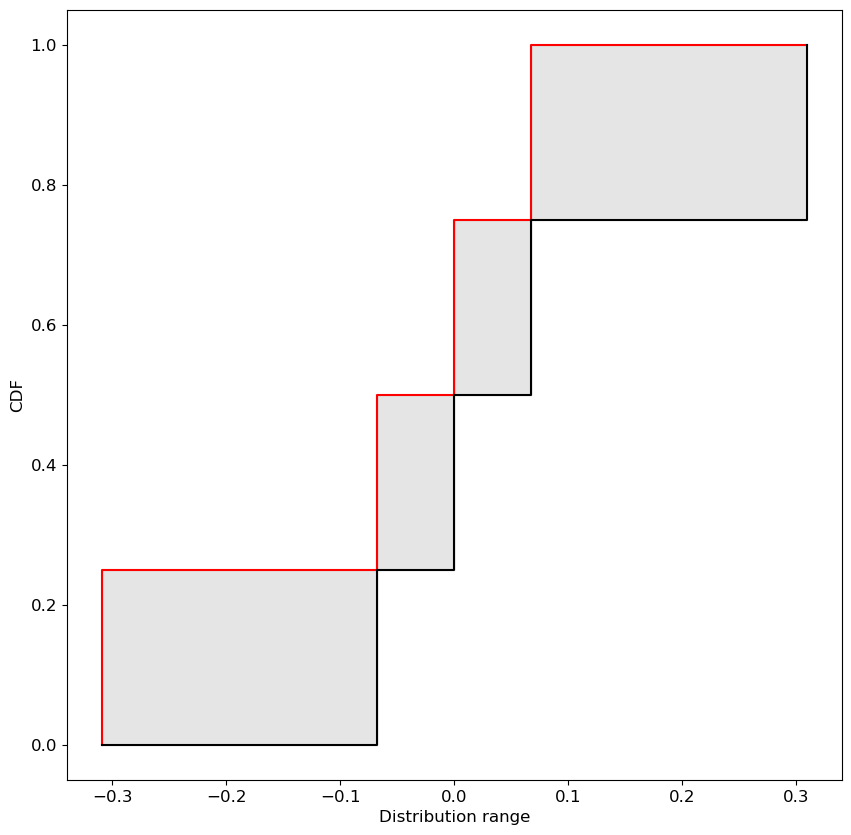

In [17]:
b = normal(0,0.1)
print(b,"\n")
PyPlot.plot(b)
PyPlot.display_figs()

Function split can be used to print the DSI representation, under the form of 
    a vector of interval focal elements and a vector of associated weights.
As far as I am aware, with this implementation it is not possible to modify the weights and they are always created equal. Which means that if you want for instance to create a focal element with double weight compared to the other elements, you need to repeat the element in the representation.

In [18]:
split(b)

(IntervalArithmetic.Interval{Float64}[[-0.309024, -0.0674489], [-0.067449, 0], [0, 0.067449], [0.0674489, 0.309024]], [0.25, 0.25, 0.25, 0.25])

You can also directly access the arrays of lower and upper bounds of the focal elements 
directly from the p-box structure:

In [19]:
print(b.u,"\n") # upper bounds focal elements
print(b.d,"\n") # lower bounds focal elements

[-0.30902323061678183, -0.06744897501960818, 0.0, 0.06744897501960818]
[-0.06744897501960818, 0.0, 0.06744897501960818, 0.30902323061678183]


## A p-box analysis of ReLU networks

We now want to write a small analysis which, given a neural network and distributions/ranges on inputs, propagates this information through the network and thus provides some information not only on the ranges of outputs, but also on associated probability distributions. 

Let us make the assumption in what follows that inputs are always independent. 

In all what follows, I suggest that you first use a low number of discretization steps to debug your implementation if necessary, and then increase it for nicer results, for instance by executing 
ProbabilityBoundsAnalysis.setSteps(100)

In [20]:
ProbabilityBoundsAnalysis.setSteps(100)

100

### Defining the Relu function on P-boxes
Let us now define the action of the Relu function on a p-box, for instance by completing the below skeleton. 

In [21]:
function Relu(x::pbox)
    u = max.(0, x.u)
    d = max.(0, x.d)
    
    y = pbox(u, d)
    return y   
end


Relu (generic function with 1 method)

Test your function with some input pbox of your choice:

In [22]:
# test ReLU with p-box normal distribution
x1 = normal(0, 1) # p-box normal distribution mean 0 variance 1
z1 = Relu(x1)  

Pbox: 	  ~  ( range=[0.0, 3.0902], mean=[0.38421, 0.41511], var=[0.30737, 0.38136])

Plotting the p-box may help you understand the results

Pbox: 	  ~  ( range=[0.0, 3.0902], mean=[0.38421, 0.41511], var=[0.30737, 0.38136])


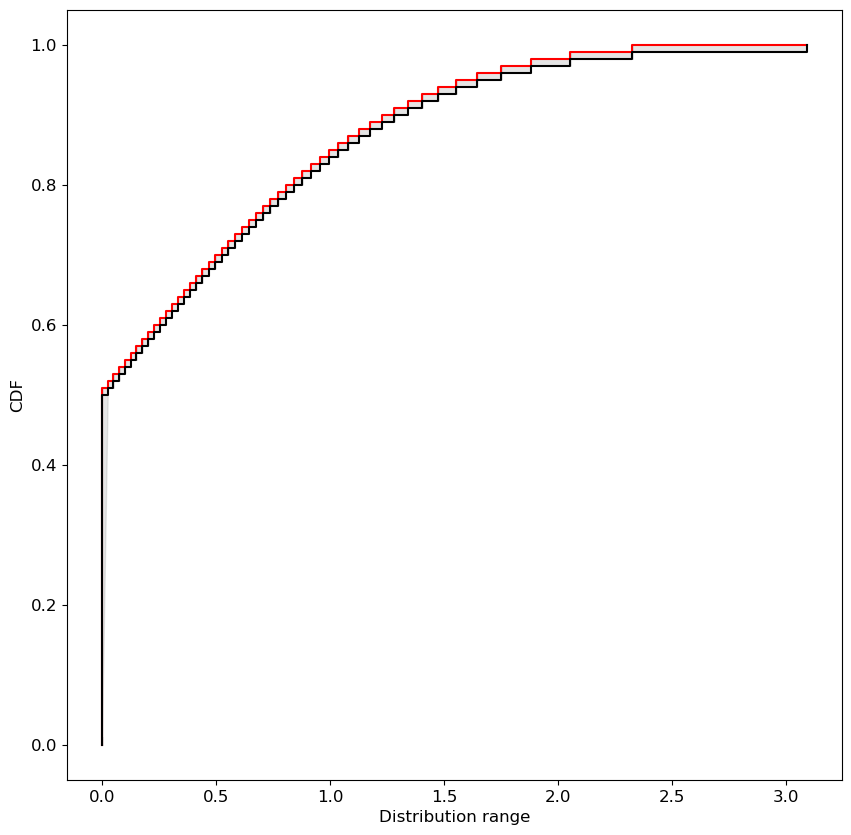

In [23]:
print(z1,"\n")
PyPlot.plot(z1)
PyPlot.display_figs()

### Putting everything together to define a neural network analysis

Remember when defining the input layers that the arithmetic operations should be chosen, depending on the correlation or not between the operands (we suppose the inputs initially independent).

In [24]:
function pbox_approximate_nnet(nnet::Network, input::Vector{pbox})
    bounds = Vector{Vector{pbox}}(undef, length(nnet.layers) + 1)
    bounds[1] = input
    for i in 1:length(nnet.layers)
        layer = nnet.layers[i]
        W, b, activation = layer.weights, layer.bias, layer.activation
        current_bounds = bounds[i]

        # Propagate through the layer
        new_bounds = Vector{pbox}(undef, length(b))
        for j in 1:length(b)
            z = fill(b[j], length(current_bounds[1].d))
            for k in 1:length(current_bounds)
                z .+= W[j, k] .* current_bounds[k].d
            end
            new_bounds[j] = activation(pbox(z, z))
        end
        
        bounds[i+1] = new_bounds
    end

    return bounds
end

function (relu::ReLU)(x::pbox)
    lower_bounds = x.d
    upper_bounds = x.u
    
    new_lower_bounds = max.(lower_bounds, 0)
    new_upper_bounds = max.(upper_bounds, 0)
    
    return pbox(new_lower_bounds, new_upper_bounds)
end

Let us now test your analysis on the toy network from the slides (slide 19).

In [25]:
W = [1.0 -1.0; 1.0 1.0]
b = [0.0, 0.0]
L1 = Layer(W, b, ReLU())
L2 = Layer(W, b, Id())
net = Network([L1, L2])

Network(Layer[Layer{ReLU, Float64}([1.0 -1.0; 1.0 1.0], [0.0, 0.0], ReLU()), Layer{Id, Float64}([1.0 -1.0; 1.0 1.0], [0.0, 0.0], Id())])

You can first run the deterministic interval analysis. 

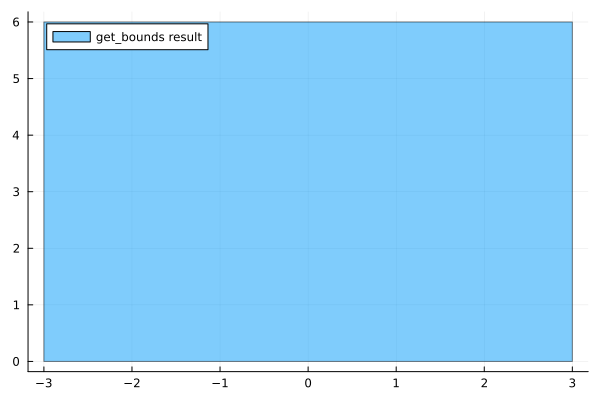

In [26]:
X = Hyperrectangle(low = [-2.0, -1.0], high = [2., 1.])
result_bounds = get_bounds(net,X)
Plots.plot(result_bounds[3], label = "get_bounds result")

In [27]:
result_bounds

3-element Vector{Hyperrectangle}:
 Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([0.0, 0.0], [2.0, 1.0])
 Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([1.5, 1.5], [1.5, 1.5])
 Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([0.0, 3.0], [3.0, 3.0])

Now the pbox analysis with Uniform input distributions (and same support as the deterministic case)

In [28]:
x1 = uniform(-2,2)
x2 = uniform(-1,1)
z = pbox_approximate_nnet(net,[x1,x2])

3-element Vector{Vector{pbox}}:
 [Pbox: 	  ~ uniform ( range=[-2.0, 2.0], mean=0.0, var=1.3333), Pbox: 	  ~ uniform ( range=[-1.0, 1.0], mean=0.0, var=0.33333)]
 [Pbox: 	  ~  ( range=[0.0, 1.0], mean=0.255, var=0.10668), Pbox: 	  ~  ( range=[0.0, 3.0], mean=0.765, var=0.96007)]
 [Pbox: 	  ~  ( range=[0.0, -2.0], mean=-0.51, var=[0.0, 0.4267]), Pbox: 	  ~  ( range=[0.0, 4.0], mean=1.02, var=1.7068)]

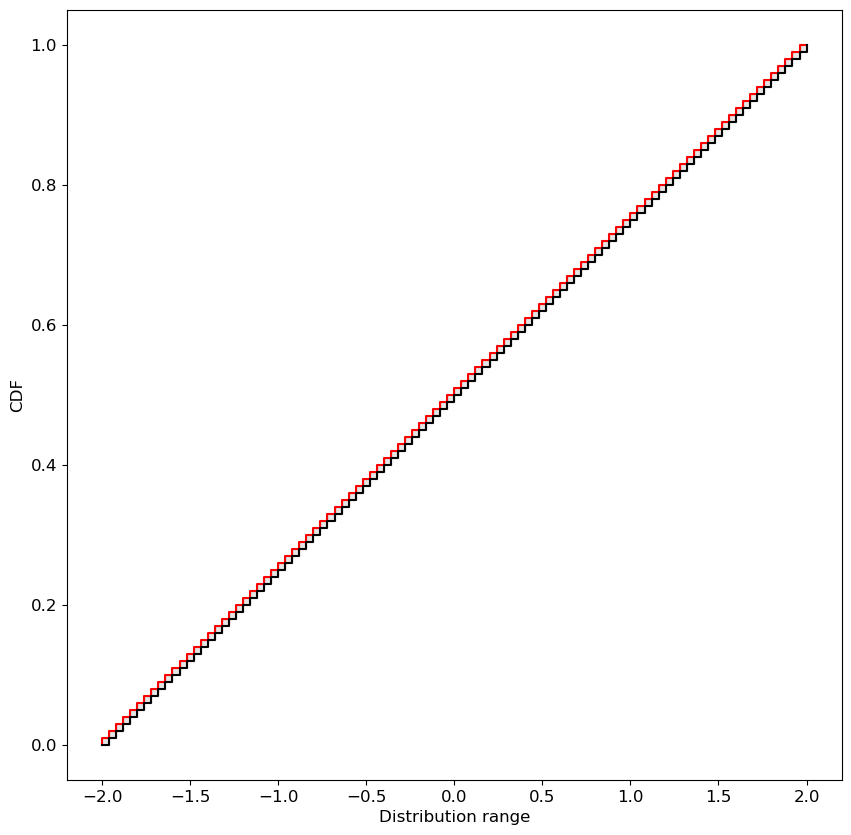

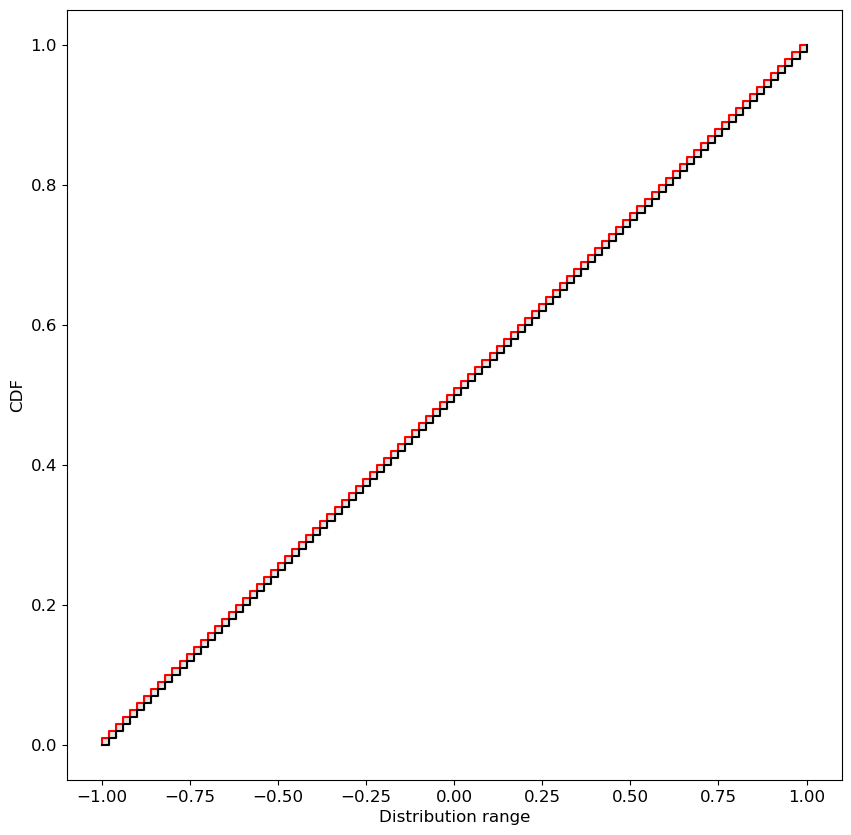

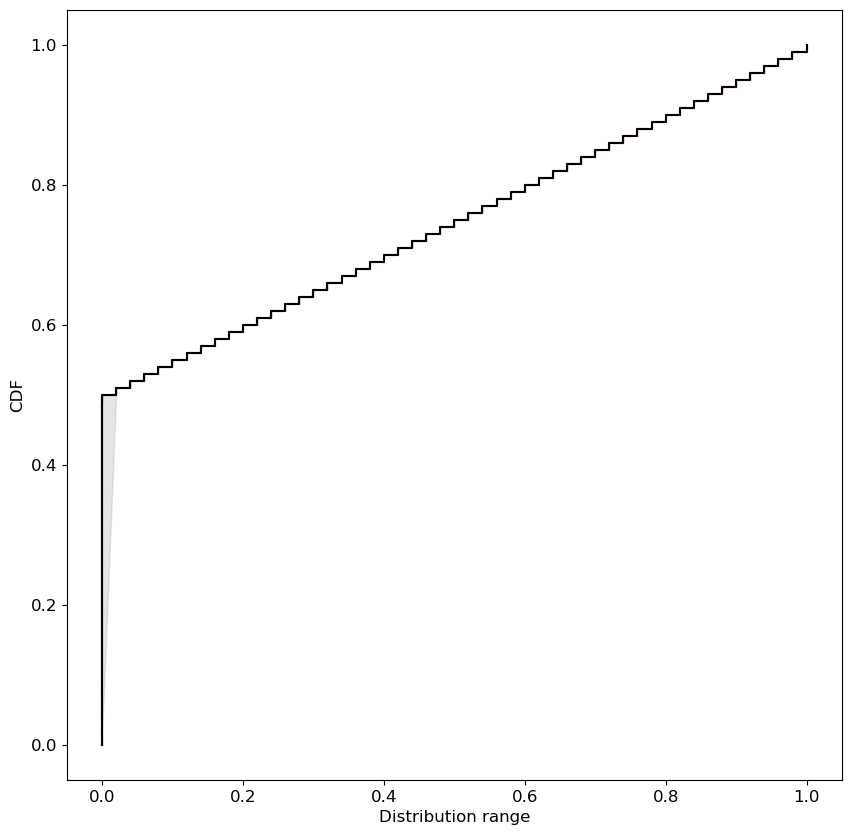

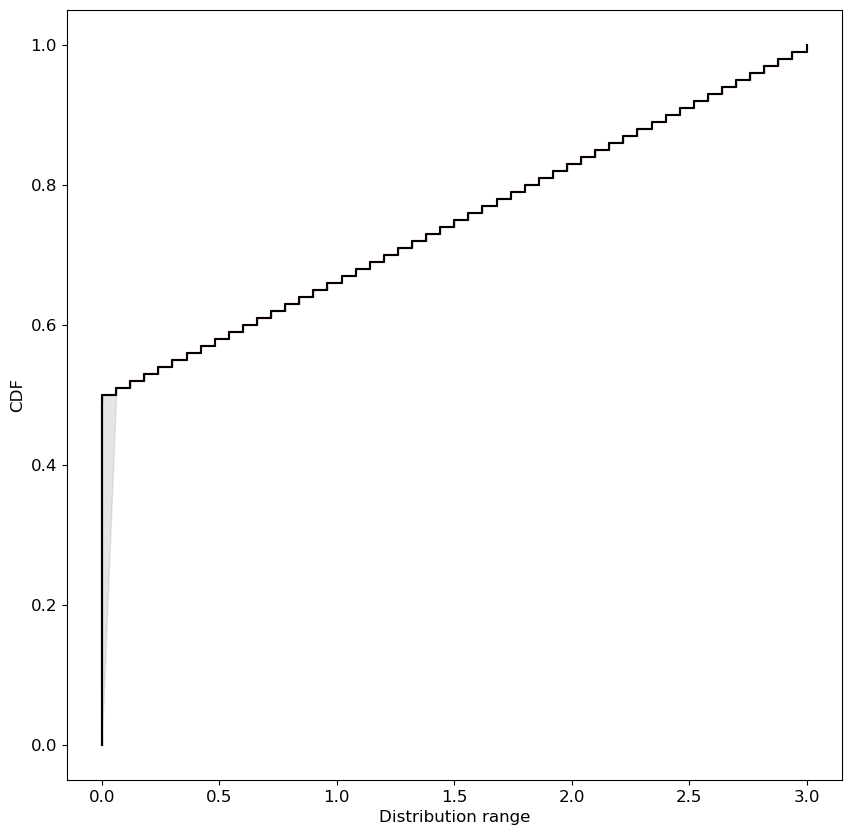

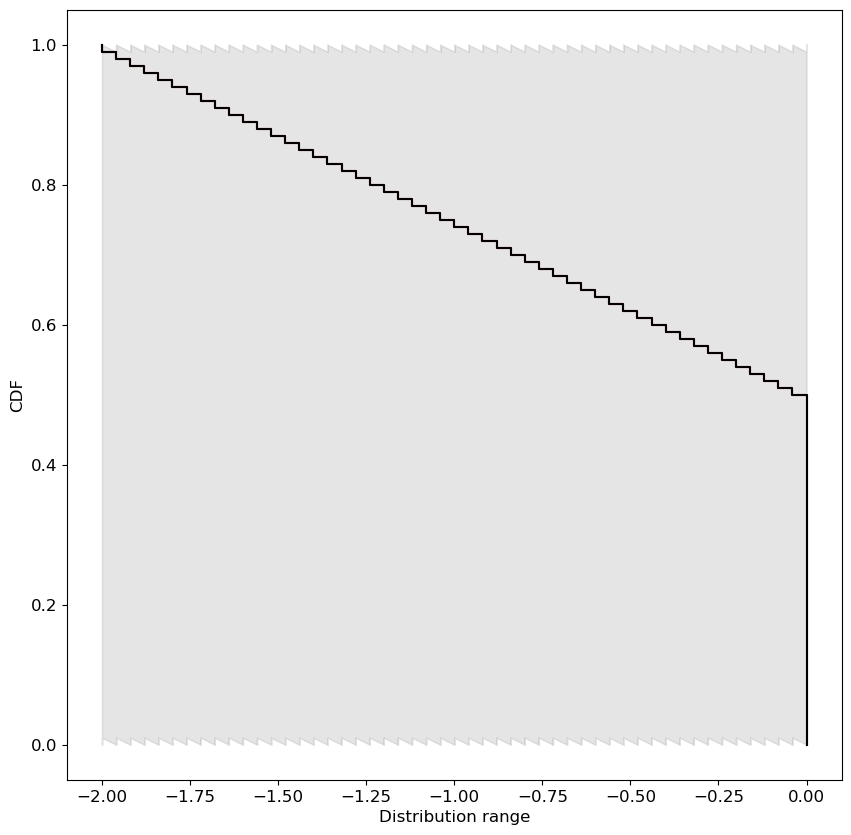

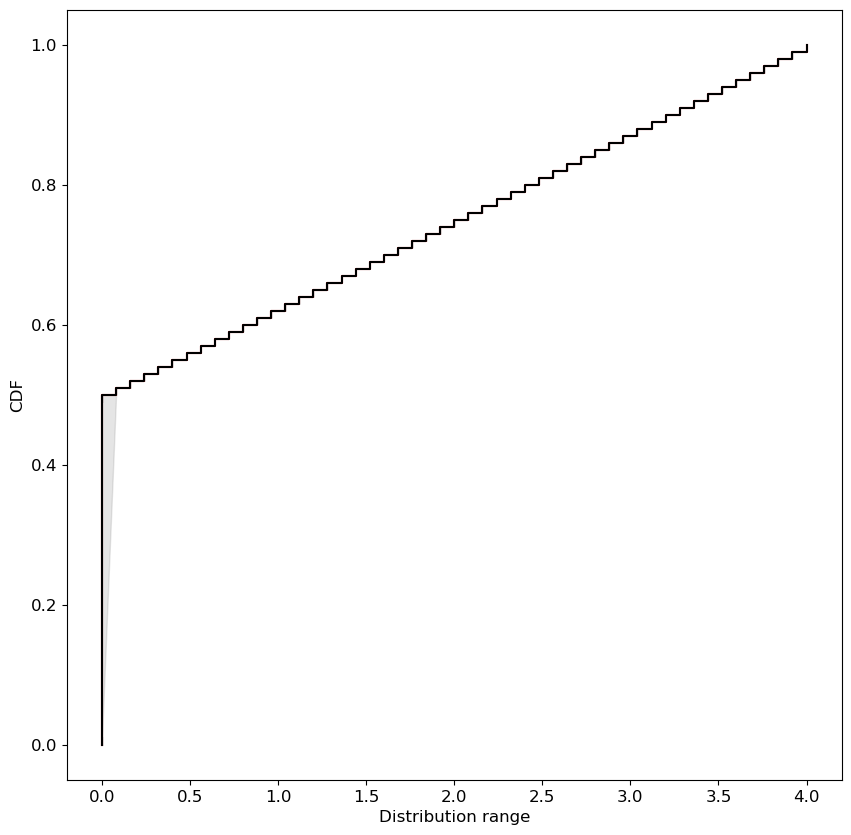

In [29]:
for i in 1:length(z)
    for j in 1:length(z[i])
        PyPlot.plot(z[i][j])
    end
end
PyPlot.display_figs()

Let us now take normal laws:

In [30]:
x1 = normal(0,interval(0.5,0.66))
x2 = normal(interval(0.,1.),0.33)
z = pbox_approximate_nnet(net,[x1,x2])

3-element Vector{Vector{pbox}}:
 [Pbox: 	  ~ normal ( range=[-2.0396, 2.0396], mean=0.0, var=[0.25, 0.4356]), Pbox: 	  ~ normal ( range=[-1.0198, 2.0198], mean=[0.0, 1.0], var=0.1089)]
 [Pbox: 	  ~  ( range=[0.0, 0.019777], mean=0.00019777, var=3.8721e-6), Pbox: 	  ~  ( range=[0.0, 4.0593], mean=1.131, var=0.73851)]
 [Pbox: 	  ~  ( range=[0.0, -4.0396], mean=-1.1308, var=[0.0, 0.73736]), Pbox: 	  ~  ( range=[0.0, 4.0791], mean=1.1312, var=0.73967)]

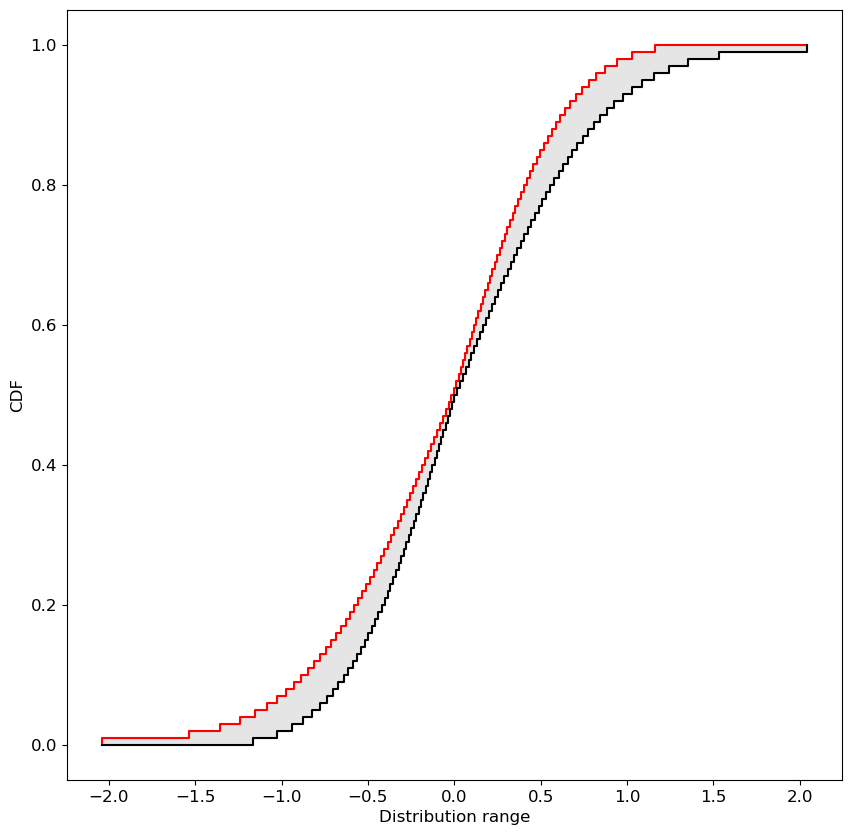

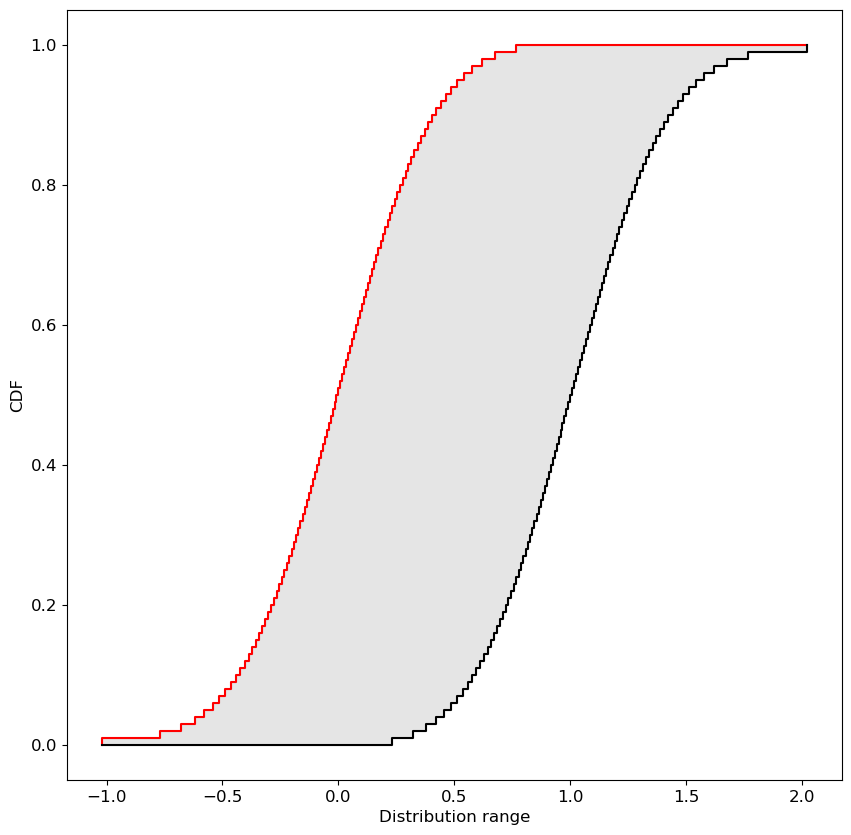

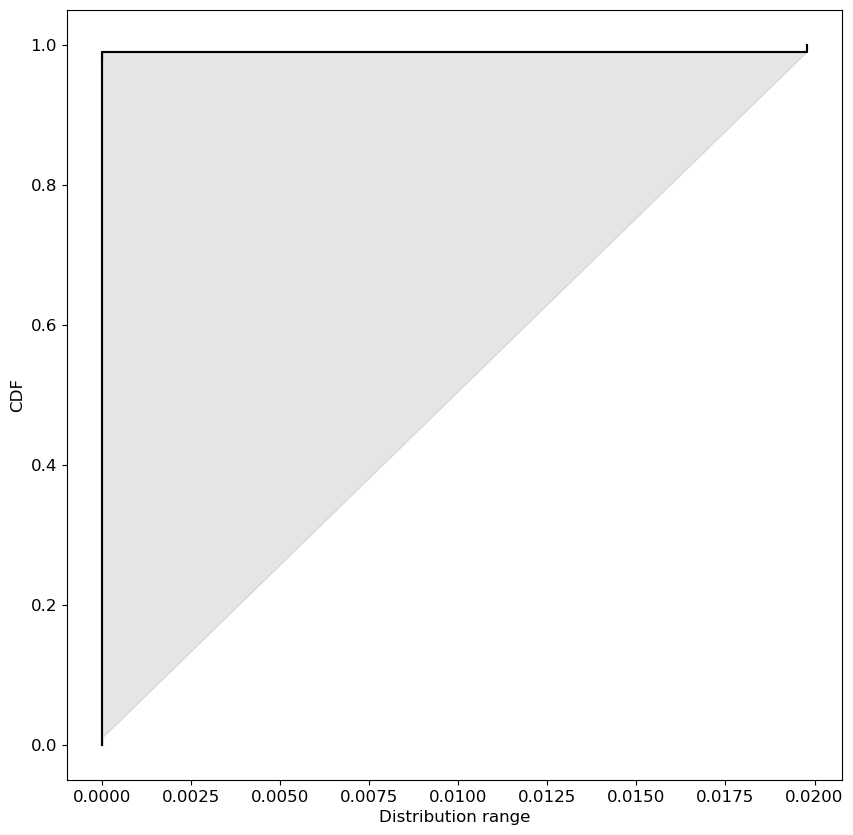

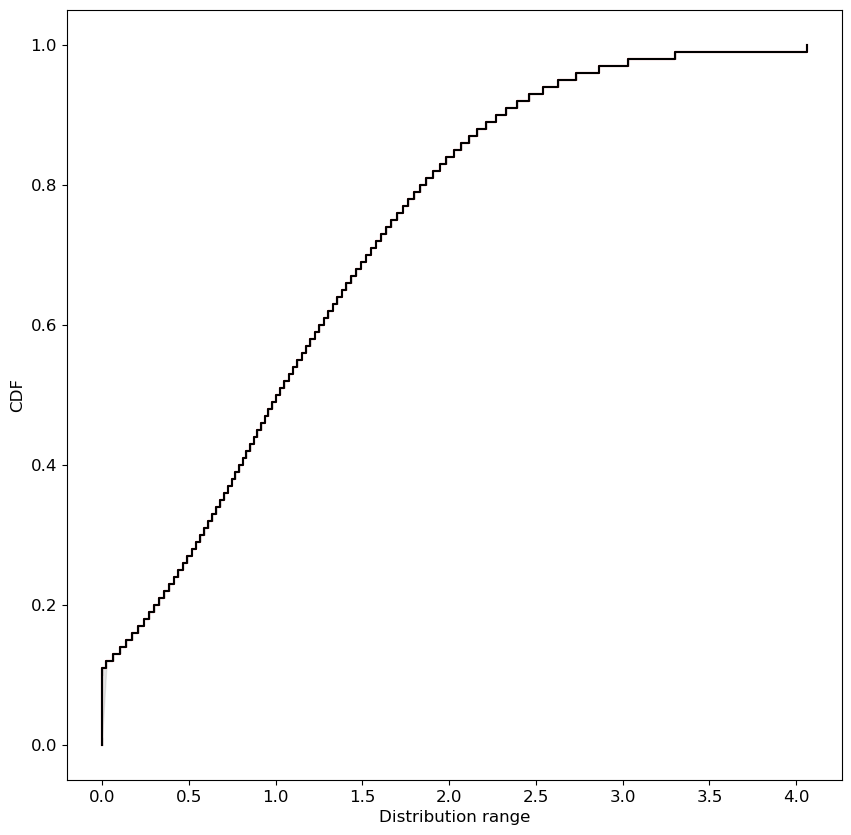

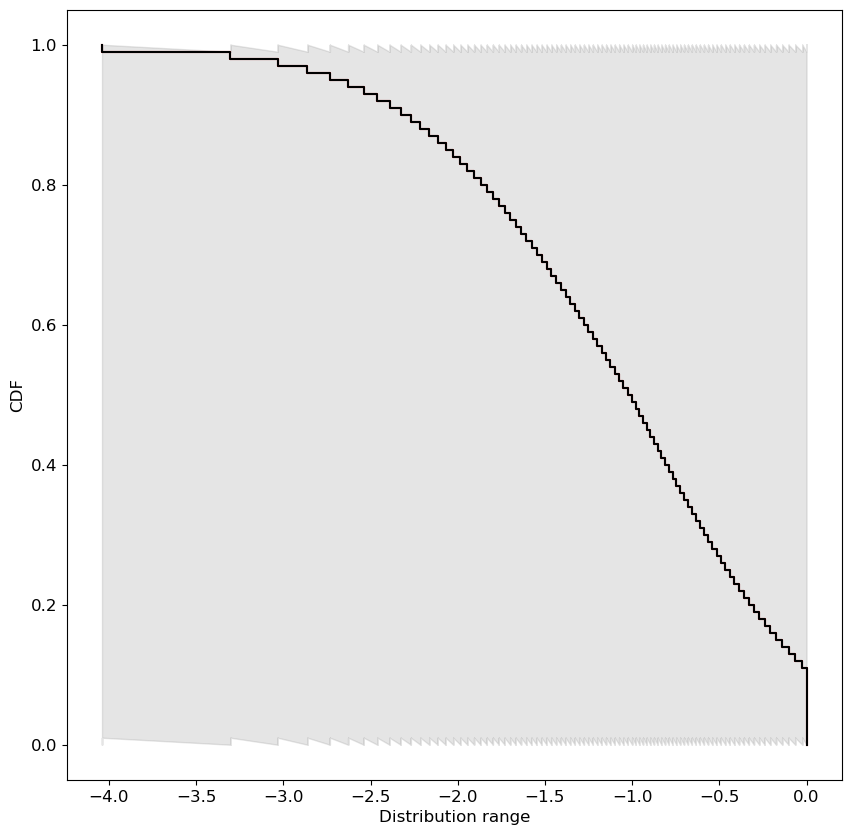

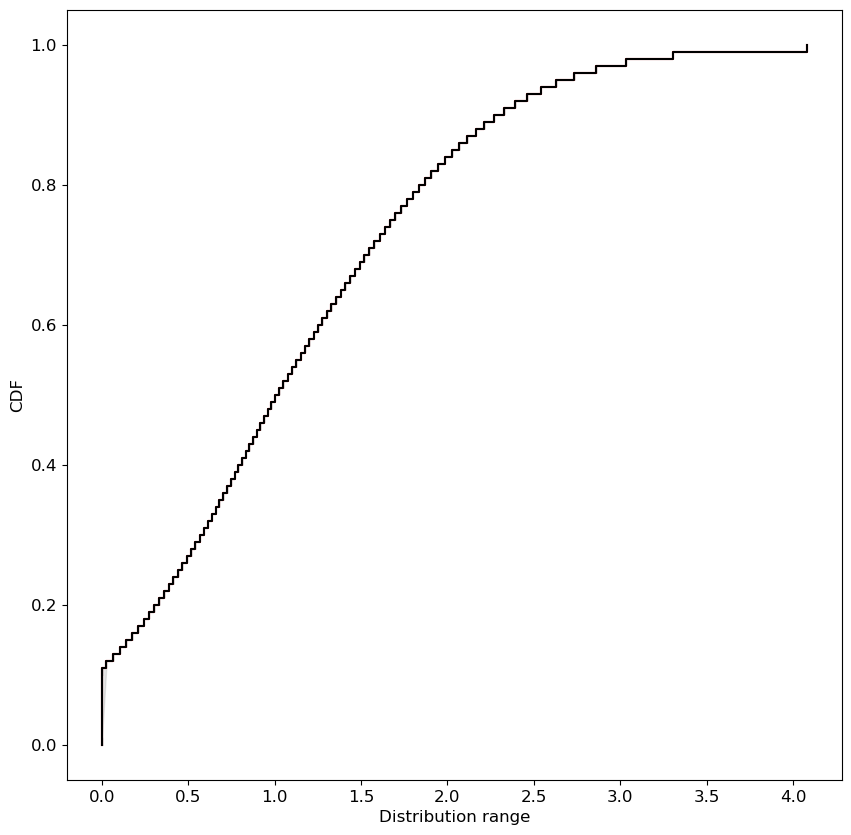

In [31]:
for i in 1:length(z)
    for j in 1:length(z[i])
        PyPlot.plot(z[i][j])
    end
end
PyPlot.display_figs()

## Going further

Try to design one (or both) of the two ways described in the slides to improve the accuracy, where the imprecise probabilities are modelled using P-boxes but the linear dependencies due to propagation in networks are handled by affine forms. 
